In [1]:
import tensorflow as tf
from keras.datasets import cifar100
from tensorflow.keras.layers import Input, Dropout, Flatten, Dense, Activation, Lambda, Conv2D, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
import datetime, os
import time
import pandas as pd
import seaborn as sns

%load_ext tensorboard

In [2]:
#Load dataset
(X_c_train, y_c_train), (X_c_test, y_c_test) = cifar100.load_data(label_mode='coarse')
(X_f_train, y_f_train), (X_f_test, y_f_test) = cifar100.load_data(label_mode='fine')

#######################
# Clusters are obtained from:
# https://github.com/stephenyan1231/caffe-public/blob/hdcnn/examples/cifar100/hdcnn/python/cifar100_NIN_raw.ipynb
# Mapping fine -> cluster
mapping_fine_to_cluster = {0: 5,1: 2,2: 3,3: 6,4: 6,5: 0,6: 2,7: 2,8: 8,9: 1,10:1,11:3,12:8,13:8,14:2,15:6,16:1,17:8,18:2,19:6,20:0,21:3,22:1,23:7,24:2,25:0,26:2,27:6,28:1,29:6,30:6,31:6,32:6,33:4,34:6,35:3,36:6,37:8,38:6,39:1,40:1,41:8,42:6,43:6,44:2,45:2,46:3,47:4,48:8,49:7,50:6,51:5,52:4,53:5,54:5,55:6,56:4,57:5,58:8,59:4,60:7,61:1,62:5,63:6,64:6,65:6,66:6,67:6,68:7,69:1,70:5,71:7,72:6,73:2,74:6,75:6,76:1,77:2,78:2,79:2,80:6,81:8,82:2,83:5,84:0,85:8,86:1,87:0,88:6,89:8,90:8,91:2,92:5,93:6,94:0,95:6,96:4,97:6,98:3,99:2}
def map_fine_to_cluster(y_f):
  y_cluster = []
  for f in  y_f:
    k = f[0]
    c = np.array([mapping_fine_to_cluster[k]])
    y_cluster.append(c)

  return np.array(y_cluster)
y_c_train = map_fine_to_cluster(y_f_train)
y_c_test = map_fine_to_cluster(y_f_test)
########################


X_train = X_f_train
X_val = X_f_test[:5000]
X_test = X_f_test[5000:]

y_train = [y_c_train, y_f_train]
y_val = [y_c_test[:5000], y_f_test[:5000]]
y_test = [y_c_test[5000:], y_f_test[5000:]]

image_size = X_train[0].shape

num_classes_c = len(set([v[0] for v in y_c_train]))
num_classes_f = len(set([v[0] for v in y_f_train]))

# Encode matrix M
M = [[0 for x in range(num_classes_f)] for y in range(num_classes_c)] 
for (c, f) in zip(y_c_train, y_f_train):
  c = c[0]
  f = f[0]
  M[c][f] = 1  





In [3]:
class global_accuracy(keras.callbacks.Callback):
    """
    Each `SquadExample` object contains the character level offsets for each token
    in its input paragraph. We use them to get back the span of text corresponding
    to the tokens between our predicted start and end tokens.
    All the ground-truth answers are also present in each `SquadExample` object.
    We calculate the percentage of data points where the span of text obtained
    from model predictions matches one of the ground-truth answers.
    """

    def __init__(self, x_eval, y_eval):
        self.x_eval = x_eval
        self.y_eval = y_eval

    def on_epoch_end(self, epoch, logs=None):
      accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c = get_metrics(self.model, self.x_eval, self.y_eval)

      accuracy_ci = 1.96 * np.std(accuracy) / np.sqrt(len(accuracy))
      accuracy = np.mean(accuracy)
      
      accuracy_c_ci = 1.96 * np.std(accuracy_c) / np.sqrt(len(accuracy_c))
      accuracy_c = np.mean(accuracy_c)
      
      accuracy_f_ci = 1.96 * np.std(accuracy_f) / np.sqrt(len(accuracy_f))
      accuracy_f = np.mean(accuracy_f)

      accuracy_c_no_f = np.mean(accuracy_c_no_f)

      accuracy_f_no_c = np.mean(accuracy_f_no_c)

      accuracy_no_f_no_c = np.mean(accuracy_no_f_no_c)
      

      print('-'*100)
      print(f"epoch={epoch+1}, global accuracy = {accuracy:.4f}±{accuracy_ci:.4f}, accuracy_c = {accuracy_c:.4f}±{accuracy_c_ci:.4f}, accuracy_f = {accuracy_f:.4f}±{accuracy_f_ci:.4f}, accuracy_c_no_f = {accuracy_c_no_f:.4f}, accuracy_f_no_c = {accuracy_f_no_c:.4f}, accuracy_no_f_no_c = {accuracy_no_f_no_c:.4f}")
      print('-'*100)
      print('')

def get_metrics(model, X, y):
  pred_c, pred_f = model.predict(X)
  accuracy = []
  accuracy_c = []
  accuracy_c_no_f = []
  accuracy_f = []
  accuracy_f_no_c = []
  accuracy_no_f_no_c = []
  for idx, (c, f) in enumerate(zip(pred_c, pred_f)):
    c = np.argmax(c)
    f = np.argmax(f)
    if y[0][idx][0] == c and y[1][idx][0] == f:
      accuracy.append(1)
      accuracy_c.append(1)
      accuracy_f.append(1)
      accuracy_c_no_f.append(0)
      accuracy_f_no_c.append(0)
      accuracy_no_f_no_c.append(0)
    elif y[0][idx][0] == c and y[1][idx][0] != f:
      accuracy.append(0)
      accuracy_c.append(1)
      accuracy_f.append(0)
      accuracy_c_no_f.append(1)
      accuracy_f_no_c.append(0)
      accuracy_no_f_no_c.append(0)
    elif y[0][idx][0] != c and y[1][idx][0] == f:
      accuracy.append(0)
      accuracy_c.append(0)
      accuracy_f.append(1)
      accuracy_c_no_f.append(0)
      accuracy_f_no_c.append(1)
      accuracy_no_f_no_c.append(0)
    else:
      accuracy.append(0)
      accuracy_c.append(0)
      accuracy_f.append(0)    
      accuracy_c_no_f.append(0)
      accuracy_f_no_c.append(0)
      accuracy_no_f_no_c.append(1)
  
  return accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c
  


In [31]:
class Custom_Layer(keras.layers.Layer):
    def __init__(self, M, mode='both'):
        super(Custom_Layer, self).__init__()
        self.M = M
        if mode in ['both', 'c_to_f', 'f_to_c']:
          self.mode = mode

    def build(self, input_shape):
        """Creates scale variable if use_scale==True."""
        if isinstance(input_shape, list):
          input_dim1 = input_shape[0][1]
          input_dim2 = input_shape[0][1]
        else:
          input_dim1 = input_shape[1]
          input_dim2 = input_shape[1]
        
        units_c = len(self.M)
        units_f = len(self.M[0])
        self.M = tf.convert_to_tensor(self.M, dtype=tf.float32)

        self.W_c = self.add_weight(
            shape=(input_dim1, units_c), initializer="random_normal", trainable=True
        )
        self.b_c = self.add_weight(shape=(units_c,), initializer="zeros", trainable=True)
        self.W_f = self.add_weight(
            shape=(input_dim2, units_f), initializer="random_normal", trainable=True
        )
        self.b_f = self.add_weight(shape=(units_f,), initializer="zeros", trainable=True)

    def call(self, inputs):
      # Code the six equation
      if isinstance(inputs, list):
        inputs1 = inputs[0]
        inputs2 = inputs[1]
      else:
        inputs1 = inputs
        inputs2 = inputs
      
      z_c = tf.matmul(inputs1, self.W_c) + self.b_c # z^{(i)}_{c}= a^{[l]} \times W_{c} + b_{c}
      z_f = tf.matmul(inputs2, self.W_f) + self.b_f #  z^{(i)}_{f}= a^{[l]} \times  W_{f}+ b_{f}
      if self.mode == 'both' or self.mode == 'f_to_c':
        m_c = tf.matmul(tf.nn.softmax(z_f), tf.transpose(self.M)) # m^{(i)}_{c}= softmax(z^{(i)}_{f})\times M^{T}            
        y_c = tf.nn.softmax(z_c * m_c) # \hat{y}^{(i)}_{c}= softmax(z^{(i)}_{c}\circ m^{(i)}_{c})
      else:
        y_c = tf.nn.softmax(z_c)

      if self.mode == 'both' or self.mode == 'c_to_f':
        m_f = tf.matmul(tf.nn.softmax(z_c), self.M) #  m^{(i)}_{f}= softmax(z^{(i)}_{c})\times M
        y_f = tf.nn.softmax(z_f * m_f) # \hat{y}^{(i)}_{f}= softmax(z^{(i)}_{f}\circ m^{(i)}_{f})
      else:
        y_f = tf.nn.softmax(z_f)

      return y_c, y_f

    def get_config(self):
        config = {'M': self.M, 
                  'W_c': self.W_c,
                  'W_f': self.W_f,
                  'b_f': self.b_f,
                  'b_f': self.b_f}
        base_config = super(Custom_Layer, self).get_config()
        return base_config
    
    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [36]:
batch = 128
epochs = 50
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
global_accuracy_callback = global_accuracy(X_val, y_val)


In [6]:
def get_model1(pi=0.5):
    # Conv base
    in_layer = Input(shape=image_size, name='main_input')
    conv_base = keras.applications.VGG19(
        include_top=False,
        weights="imagenet")(in_layer)
    conv_base = Flatten()(conv_base)
    # coarse output
    out_c = Dense(num_classes_c, activation="softmax", name='out_c')(conv_base)
    # fine output 
    out_f = Dense(num_classes_f, activation="softmax", name='out_f')(conv_base)
    # Build the model
    model = Model(name='Model_1',
            inputs=in_layer,
            outputs=[out_c, out_f])
    loss = keras.losses.SparseCategoricalCrossentropy()
    optimizer = keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(optimizer=optimizer, 
                  loss=[loss, loss],
                  loss_weights=[1-pi, pi],
                  metrics=['accuracy'])
    return model

# model = get_model1()
# model.summary()
# plot_model(model)

In [7]:
def get_model2(pi=0.5):
    # Conv base
    in_layer = Input(shape=image_size, name='main_input')
    conv_base = keras.applications.VGG19(
        include_top=False,
        weights="imagenet")(in_layer)
    conv_base = Flatten()(conv_base)
    # coarse output
    out_c = Dense(num_classes_c, activation="softmax", name='out_c')(conv_base)
    # fine output 
    out_f = Dense(num_classes_f, activation="softmax", name='out_f')(out_c)
    # Build the model
    model = Model(name='Model_2',
            inputs=in_layer,
            outputs=[out_c, out_f])
    loss = keras.losses.SparseCategoricalCrossentropy()
    optimizer = keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(optimizer=optimizer, 
                  loss=[loss, loss],
                  loss_weights=[1-pi, pi],
                  metrics=['accuracy'])
    return model

# model = get_model2()
# model.summary()
# plot_model(model)

In [8]:
def get_model3(pi=0.5):
    # Conv base
    in_layer = Input(shape=image_size, name='main_input')
    conv_base = keras.applications.VGG19(
        include_top=False,
        weights="imagenet")(in_layer)
    conv_base = Flatten()(conv_base)    
    # fine output 
    out_f = Dense(num_classes_f, activation="softmax", name='out_f')(conv_base)
    # coarse output
    out_c = Dense(num_classes_c, activation="softmax", name='out_c')(out_f)
    # Build the model
    model = Model(name='Model_3',
            inputs=in_layer,
            outputs=[out_c, out_f])
    loss = keras.losses.SparseCategoricalCrossentropy()
    optimizer = keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(optimizer=optimizer, 
                  loss=[loss, loss],
                  loss_weights=[1-pi, pi],
                  metrics=['accuracy'])
    return model

# model = get_model3()
# model.summary()
# plot_model(model)

In [9]:
def get_model4(pi=0.5):
    # Conv base
    in_layer = Input(shape=image_size, name='main_input')
    conv_base = keras.applications.VGG19(
        include_top=False,
        weights="imagenet")(in_layer)
    conv_base = Flatten()(conv_base)
    # coarse output
    logits_c = Dense(num_classes_c, name='logits_c')(conv_base)
    out_c = Activation(keras.activations.softmax, name='out_c')(logits_c)
    
    # fine output 
    relu_c = Activation(keras.activations.relu, name='relu_c')(logits_c)
    out_f = Dense(num_classes_f, activation="softmax", name='out_f')(relu_c)
    # Build the model
    model = Model(name='Model_4',
            inputs=in_layer,
            outputs=[out_c, out_f])
    loss = keras.losses.SparseCategoricalCrossentropy()
    optimizer = keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(optimizer=optimizer, 
                  loss=[loss, loss],
                  loss_weights=[1-pi, pi],
                  metrics=['accuracy'])
    return model

# model = get_model4()
# model.summary()
# plot_model(model)


In [10]:
def get_model5(pi=0.5):
    # Conv base
    in_layer = Input(shape=image_size, name='main_input')
    conv_base = keras.applications.VGG19(
        include_top=False,
        weights="imagenet")(in_layer)
    conv_base = Flatten()(conv_base)
    # coarse output
    logits_f = Dense(num_classes_f, name='logits_f')(conv_base)
    relu_f = Activation(keras.activations.relu, name='relu_f')(logits_f)
    out_c = Dense(num_classes_c, activation="softmax", name='out_c')(relu_f)
    # fine output 
    out_f = Activation(keras.activations.softmax, name='out_f')(logits_f)
    # Build the model
    model = Model(name='Model_5',
            inputs=in_layer,
            outputs=[out_c, out_f])
    loss = keras.losses.SparseCategoricalCrossentropy()
    optimizer = keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(optimizer=optimizer, 
                  loss=[loss, loss],
                  loss_weights=[1-pi, pi],
                  metrics=['accuracy'])
    return model

# model = get_model5()
# model.summary()
# plot_model(model)


In [11]:
def get_model6(pi=0.5):
    # Conv base
    conv_base1 = keras.applications.VGG19(
    include_top=False,
    weights="imagenet")
    conv_base1._name = 'vgg19_1'
    conv_base2 = keras.applications.VGG19(
        include_top=False,
        weights="imagenet")
    conv_base2._name = 'vgg19_2'
    in_layer = Input(shape=image_size, name='main_input')
    conv_base1 = conv_base1(in_layer)    
    conv_base1 = Flatten()(conv_base1)

    conv_base2 = conv_base2(in_layer)
    conv_base2 = Flatten()(conv_base2)
    # coarse output
    out_c = Dense(num_classes_c, activation="softmax", name='out_c')(conv_base1)
    # fine output 
    out_f = Dense(num_classes_f, activation="softmax", name='out_f')(conv_base2)
    # Build the model
    model = Model(name='Model_6',
            inputs=in_layer,
            outputs=[out_c, out_f])
    loss = keras.losses.SparseCategoricalCrossentropy()
    optimizer = keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(optimizer=optimizer, 
                  loss=[loss, loss],
                  loss_weights=[1-pi, pi],
                  metrics=['accuracy'])
    return model

# model = get_model6()
# model.summary()
# plot_model(model)

In [27]:
def get_model7(pi=0.5, mode='both'):
    # Conv base
    in_layer = Input(shape=image_size, name='main_input')
    conv_base = keras.applications.VGG19(
        include_top=False,
        weights="imagenet")(in_layer)
    conv_base = Flatten()(conv_base)
    # outputs 
    out_c, out_f = Custom_Layer(M, mode)(conv_base)
    # Build the model
    model = Model(name='Model_7',
            inputs=in_layer,
            outputs=[out_c, out_f])
    loss = keras.losses.SparseCategoricalCrossentropy()
    optimizer = keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(optimizer=optimizer, 
                  loss=[loss, loss],
                  loss_weights=[1-pi, pi],
                  metrics=['accuracy'])
    return model

# model = get_model7()
# model.summary()
# plot_model(model)


In [22]:
def get_model8(pi=0.5, mode='both'):
    # Conv base
    conv_base1 = keras.applications.VGG19(
    include_top=False,
    weights="imagenet")
    conv_base1._name = 'vgg19_1'
    conv_base2 = keras.applications.VGG19(
        include_top=False,
        weights="imagenet")
    conv_base2._name = 'vgg19_2'
    in_layer = Input(shape=image_size, name='main_input')
    conv_base1 = conv_base1(in_layer)    
    conv_base1 = Flatten()(conv_base1)

    conv_base2 = conv_base2(in_layer)
    conv_base2 = Flatten()(conv_base2)

    out_c, out_f = Custom_Layer(M, mode)([conv_base1, conv_base2])
    # Build the model
    model = Model(name='Model_8',
            inputs=in_layer,
            outputs=[out_c, out_f])
    loss = keras.losses.SparseCategoricalCrossentropy()
    optimizer = keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(optimizer=optimizer, 
                  loss=[loss, loss],
                  loss_weights=[1-pi, pi],
                  metrics=['accuracy'])
    return model

# model = get_model8()
# model.summary()
# plot_model(model)

In [ ]:
# Create the model
model1_pi1 = get_model1(1)
model1_pi1.summary()
#train model
history_model1_pi1 = model1_pi1.fit(X_train, 
                    y_train,
                    validation_data = (X_val, y_val), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[tensorboard_callback, global_accuracy_callback, early_stopping_callback])
plot_model(model1_pi1)



In [ ]:
# Create the model
model1_pi0 = get_model1(0)
model1_pi0.summary()
#train model
history_model1_pi0 = model1_pi0.fit(X_train, 
                    y_train,
                    validation_data = (X_val, y_val), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[tensorboard_callback, global_accuracy_callback, early_stopping_callback])
plot_model(model1_pi0)



Model: "Model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
vgg19 (Functional)              (None, None, None, 5 20024384    main_input[0][0]                 
__________________________________________________________________________________________________
flatten_22 (Flatten)            (None, 512)          0           vgg19[0][0]                      
__________________________________________________________________________________________________
out_c (Dense)                   (None, 9)            4617        flatten_22[0][0]                 
____________________________________________________________________________________________

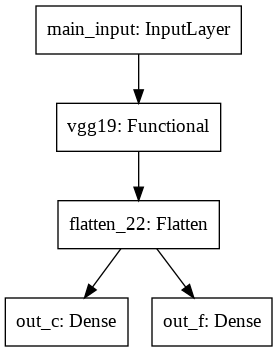

In [47]:
# Create the model
model1_pi0_5 = get_model1(0.5)
model1_pi0_5.summary()
#train model
history_model11_pi0_5 = model1_pi0_5.fit(X_train, 
                    y_train,
                    validation_data = (X_val, y_val), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[tensorboard_callback, global_accuracy_callback])
plot_model(model1_pi0_5)


In [ ]:
# Create the model
model2 = get_model2(0.5)
model2.summary()
#train model
history_model2 = model2.fit(X_train, 
                    y_train,
                    validation_data = (X_val, y_val), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[tensorboard_callback, global_accuracy_callback, early_stopping_callback])
plot_model(model2)


In [ ]:
# Create the model
model3 = get_model3(0.5)
model.summary()
#train model
history_model3 = model3.fit(X_train, 
                    y_train,
                    validation_data = (X_val, y_val), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[tensorboard_callback, global_accuracy_callback, early_stopping_callback])
plot_model(model3)


In [ ]:
# Create the model
model4 = get_model4(0.5)
model4.summary()
#train model
history_model4 = model4.fit(X_train, 
                    y_train,
                    validation_data = (X_val, y_val), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[tensorboard_callback, global_accuracy_callback, early_stopping_callback])
plot_model(model4)


In [ ]:
# Create the model
model5 = get_model5(0.5)
model5.summary()
#train model
history_model5 = model5.fit(X_train, 
                    y_train,
                    validation_data = (X_val, y_val), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[tensorboard_callback, global_accuracy_callback, early_stopping_callback])
plot_model(model5)


Model: "Model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
vgg19_1 (Functional)            (None, None, None, 5 20024384    main_input[0][0]                 
__________________________________________________________________________________________________
vgg19_2 (Functional)            (None, None, None, 5 20024384    main_input[0][0]                 
__________________________________________________________________________________________________
flatten_19 (Flatten)            (None, 512)          0           vgg19_1[0][0]                    
____________________________________________________________________________________________

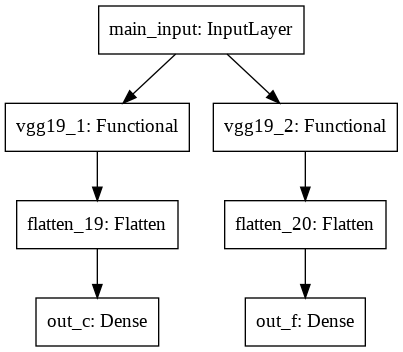

In [45]:
# Create the model
model6 = get_model6(0.5)
model6.summary()
#train model
history_model6 = model6.fit(X_train, 
                    y_train,
                    validation_data = (X_val, y_val), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[tensorboard_callback, global_accuracy_callback, early_stopping_callback])
plot_model(model6)



Model: "Model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 32, 32, 3)]       0         
_________________________________________________________________
vgg19 (Functional)           (None, None, None, 512)   20024384  
_________________________________________________________________
flatten_14 (Flatten)         (None, 512)               0         
_________________________________________________________________
custom__layer_10 (Custom_Lay ((None, 9), (None, 100))  55917     
Total params: 20,080,301
Trainable params: 20,080,301
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
391/391 [==============================] - 17s 42ms/step - loss: 3.4735 - custom__layer_10_loss: 2.1017 - custom__layer_10_1_loss: 4.8453 - custom__layer_10_accuracy: 0.2988 - custom__layer_10_1_accuracy: 0.0215 - val_loss: 3.1868 - v

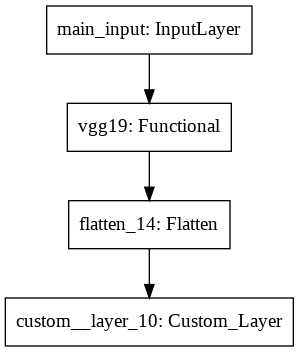

In [41]:
# Create the model
model7 = get_model7(0.5)
model7.summary()
#train model
history_model7 = model7.fit(X_train, 
                    y_train,
                    validation_data = (X_val, y_val), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[tensorboard_callback, global_accuracy_callback])
plot_model(model7)


Model: "Model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 32, 32, 3)]       0         
_________________________________________________________________
vgg19 (Functional)           (None, None, None, 512)   20024384  
_________________________________________________________________
flatten_15 (Flatten)         (None, 512)               0         
_________________________________________________________________
custom__layer_11 (Custom_Lay ((None, 9), (None, 100))  55917     
Total params: 20,080,301
Trainable params: 20,080,301
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
391/391 [==============================] - 17s 42ms/step - loss: 3.4840 - custom__layer_11_loss: 2.1376 - custom__layer_11_1_loss: 4.8304 - custom__layer_11_accuracy: 0.3816 - custom__layer_11_1_accuracy: 0.0275 - val_loss: 2.8527 - v

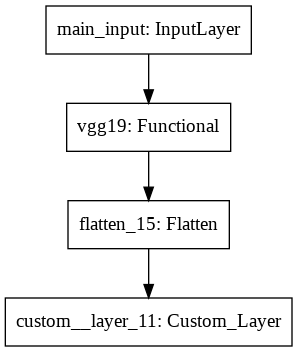

In [42]:
# Create the model
model7_c_to_f = get_model7(0.5, mode='c_to_f')
model7_c_to_f.summary()
#train model
history_model7_c_to_f = model7_c_to_f.fit(X_train, 
                    y_train,
                    validation_data = (X_val, y_val), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[tensorboard_callback, global_accuracy_callback])
plot_model(model7_c_to_f)


Model: "Model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 32, 32, 3)]       0         
_________________________________________________________________
vgg19 (Functional)           (None, None, None, 512)   20024384  
_________________________________________________________________
flatten_16 (Flatten)         (None, 512)               0         
_________________________________________________________________
custom__layer_12 (Custom_Lay ((None, 9), (None, 100))  55917     
Total params: 20,080,301
Trainable params: 20,080,301
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
391/391 [==============================] - 17s 42ms/step - loss: 3.7453 - custom__layer_12_loss: 2.2524 - custom__layer_12_1_loss: 5.2382 - custom__layer_12_accuracy: 0.2859 - custom__layer_12_1_accuracy: 0.0251 - val_loss: 3.2810 - v

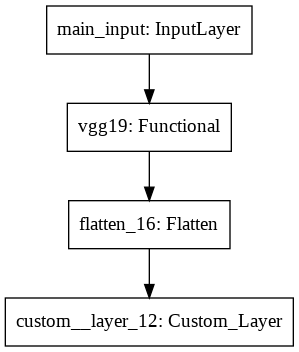

In [43]:
# Create the model
model7_f_to_c = get_model7(0.5, mode='f_to_c')
model7_f_to_c.summary()
#train model
history_model7_f_to_c = model7_f_to_c.fit(X_train, 
                    y_train,
                    validation_data = (X_val, y_val), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[tensorboard_callback, global_accuracy_callback])
plot_model(model7_f_to_c)


Model: "Model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
vgg19_1 (Functional)            (None, None, None, 5 20024384    main_input[0][0]                 
__________________________________________________________________________________________________
vgg19_2 (Functional)            (None, None, None, 5 20024384    main_input[0][0]                 
__________________________________________________________________________________________________
flatten_5 (Flatten)             (None, 512)          0           vgg19_1[0][0]                    
____________________________________________________________________________________________

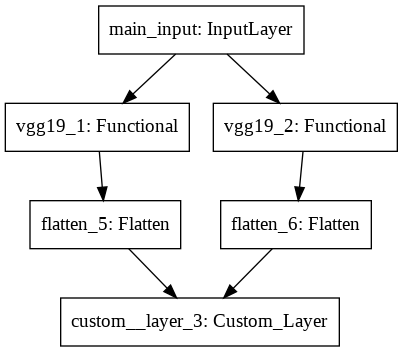

In [30]:
# # # Create the model
model8 = get_model8(0.5)
model8.summary()
plot_model(model8)
#train model
history_model8 = model8.fit(X_train, 
                    y_train,
                    validation_data = (X_val, y_val), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[tensorboard_callback, global_accuracy_callback, early_stopping_callback])
plot_model(model8)



In [ ]:
data = pd.DataFrame(columns=['algo','accuracy','accuracy_c', 'accuracy_f'])

accuracy, accuracy_c, accuracy_f = get_metrics(model1_pi1, X_test, y_test)
data_list = list(zip(['model1_pi1']*len(accuracy), accuracy, accuracy_c, accuracy_f))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f']),ignore_index=True)

accuracy, accuracy_c, accuracy_f = get_metrics(model1_pi0, X_test, y_test)
data_list = list(zip(['model1_pi0']*len(accuracy), accuracy, accuracy_c, accuracy_f))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f']),ignore_index=True)

accuracy, accuracy_c, accuracy_f = get_metrics(model1_pi0_5, X_test, y_test)
data_list = list(zip(['model1_pi0.5']*len(accuracy), accuracy, accuracy_c, accuracy_f))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f']),ignore_index=True)

accuracy, accuracy_c, accuracy_f = get_metrics(model2, X_test, y_test)
data_list = list(zip(['model2']*len(accuracy), accuracy, accuracy_c, accuracy_f))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f']),ignore_index=True)

accuracy, accuracy_c, accuracy_f = get_metrics(model3, X_test, y_test)
data_list = list(zip(['model3']*len(accuracy), accuracy, accuracy_c, accuracy_f))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f']),ignore_index=True)

accuracy, accuracy_c, accuracy_f = get_metrics(model4, X_test, y_test)
data_list = list(zip(['model4']*len(accuracy), accuracy, accuracy_c, accuracy_f))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f']),ignore_index=True)

accuracy, accuracy_c, accuracy_f = get_metrics(model5, X_test, y_test)
data_list = list(zip(['model5']*len(accuracy), accuracy, accuracy_c, accuracy_f))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f']),ignore_index=True)

accuracy, accuracy_c, accuracy_f = get_metrics(model6, X_test, y_test)
data_list = list(zip(['model6']*len(accuracy), accuracy, accuracy_c, accuracy_f))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f']),ignore_index=True)

accuracy, accuracy_c, accuracy_f = get_metrics(model7, X_test, y_test)
data_list = list(zip(['model7']*len(accuracy), accuracy, accuracy_c, accuracy_f))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f']),ignore_index=True)

accuracy, accuracy_c, accuracy_f = get_metrics(model8, X_test, y_test)
data_list = list(zip(['model8']*len(accuracy), accuracy, accuracy_c, accuracy_f))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f']),ignore_index=True)


In [ ]:
# statistic, pvalue = stats.ttest_ind(acc2, acc_baseline2)
plt.figure(figsize=(10, 3.8))

ax = sns.barplot(x="algo", y="accuracy", data=data, ci=95, capsize=.2)
# ax.text(.5,.87,f"p-value = {pvalue:.4f} ≮ 0.05",
#         horizontalalignment='center',
#         transform=ax.transAxes,
#        bbox=dict(facecolor='white', edgecolor='none'))
ax.grid(color='black', linestyle='--', linewidth=1)
ax.set_axisbelow(True)

plt.xlabel("")
plt.ylabel("Accuracy")
# plt.title("Box plot of #candidates per cycle and system")
params = {'legend.fontsize': 18,
          'axes.labelsize': 20,
          'axes.titlesize': 14,
          'xtick.labelsize': 20,
          'ytick.labelsize': 18,
          'axes.titlepad': 25,
          'font.size': 24}
plt.rcParams.update(params)
plt.ylim(0.0, 0.5)
plt.xticks(rotation=90)
# plt.savefig('plots/em_SQuAD2.0.eps', bbox_inches = 'tight')
plt.show()

In [ ]:
# statistic, pvalue = stats.ttest_ind(acc2, acc_baseline2)
plt.figure(figsize=(10, 3.8))

ax = sns.barplot(x="algo", y="accuracy_c", data=data, ci=95, capsize=.2)
# ax.text(.5,.87,f"p-value = {pvalue:.4f} ≮ 0.05",
#         horizontalalignment='center',
#         transform=ax.transAxes,
#        bbox=dict(facecolor='white', edgecolor='none'))
ax.grid(color='black', linestyle='--', linewidth=1)
ax.set_axisbelow(True)

plt.xlabel("")
plt.ylabel("Accuracy_c")
# plt.title("Box plot of #candidates per cycle and system")
params = {'legend.fontsize': 18,
          'axes.labelsize': 20,
          'axes.titlesize': 14,
          'xtick.labelsize': 20,
          'ytick.labelsize': 18,
          'axes.titlepad': 25,
          'font.size': 24}
plt.rcParams.update(params)
plt.ylim(0.0, 0.9)
plt.xticks(rotation=90)
# plt.savefig('plots/em_SQuAD2.0.eps', bbox_inches = 'tight')
plt.show()

In [ ]:
# statistic, pvalue = stats.ttest_ind(acc2, acc_baseline2)
plt.figure(figsize=(10, 3.8))

ax = sns.barplot(x="algo", y="accuracy_f", data=data, ci=95, capsize=.2)
# ax.text(.5,.87,f"p-value = {pvalue:.4f} ≮ 0.05",
#         horizontalalignment='center',
#         transform=ax.transAxes,
#        bbox=dict(facecolor='white', edgecolor='none'))
ax.grid(color='black', linestyle='--', linewidth=1)
ax.set_axisbelow(True)

plt.xlabel("")
plt.ylabel("Accuracy_f")
# plt.title("Box plot of #candidates per cycle and system")
params = {'legend.fontsize': 18,
          'axes.labelsize': 20,
          'axes.titlesize': 14,
          'xtick.labelsize': 20,
          'ytick.labelsize': 18,
          'axes.titlepad': 25,
          'font.size': 24}
plt.rcParams.update(params)
plt.ylim(0.0, 0.6)
plt.xticks(rotation=90)
# plt.savefig('plots/em_SQuAD2.0.eps', bbox_inches = 'tight')
plt.show()

In [ ]:
data_ = data[data.algo.isin(['model1_pi0.5', 'model5', 'model6'])]
# statistic, pvalue = stats.ttest_ind(acc2, acc_baseline2)
plt.figure(figsize=(10, 3.8))

ax = sns.barplot(x="algo", y="accuracy", data=data_, ci=95, capsize=.2)
# ax.text(.5,.87,f"p-value = {pvalue:.4f} ≮ 0.05",
#         horizontalalignment='center',
#         transform=ax.transAxes,
#        bbox=dict(facecolor='white', edgecolor='none'))
ax.grid(color='black', linestyle='--', linewidth=1)
ax.set_axisbelow(True)

plt.xlabel("")
plt.ylabel("Accuracy")
# plt.title("Box plot of #candidates per cycle and system")
params = {'legend.fontsize': 18,
          'axes.labelsize': 20,
          'axes.titlesize': 14,
          'xtick.labelsize': 20,
          'ytick.labelsize': 18,
          'axes.titlepad': 25,
          'font.size': 24}
plt.rcParams.update(params)
plt.ylim(0.4, 0.47)
plt.xticks(rotation=90)
# plt.savefig('plots/em_SQuAD2.0.eps', bbox_inches = 'tight')
plt.show()

In [ ]:
out_f_accuracy = history.history['out_f_accuracy']
out_c_accuracy = history.history['out_c_accuracy']
val_out_f_accuracy = history.history['val_out_f_accuracy']
val_out_c_accuracy = history.history['val_out_c_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(15,4))

ax1 = plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.fill_between(epochs, loss,val_loss,color='g',alpha=.1)

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

ax2 = plt.subplot(1, 2, 2)
plt.plot(epochs, out_f_accuracy, label='Training f accuracy')
plt.plot(epochs, out_c_accuracy, label='Training c accuracy')
plt.plot(epochs, val_out_f_accuracy, label='Validation f accuracy')
plt.plot(epochs, val_out_c_accuracy, label='Validation c accuracy')
# plt.fill_between(epochs, acc,val_acc,color='g',alpha=.1)
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [41]:
def nin(input_shape):
    # Define Network in Network model
    input = Input(shape=input_shape)
    x = Conv2D(filters=192, kernel_size=(5,5), activation='relu')(input)
    x = Conv2D(filters=160, kernel_size=(1,1), activation='relu')(x)
    x = Conv2D(filters=96, kernel_size=(1,1), activation='relu')(x)
    x = MaxPool2D(2, strides=2, padding='same')(x)
    x = Dropout(0.5)(x)

    x = Conv2D(filters=192, kernel_size=(5,5), activation='relu')(x)
    x = Conv2D(filters=192, kernel_size=(1,1), activation='relu')(x)
    x = Conv2D(filters=192, kernel_size=(1,1), activation='relu')(x)
    x = MaxPool2D(2, strides=2, padding='same')(x)
    x = Dropout(0.5)(x)

    x = Conv2D(filters=192, kernel_size=(3,3), activation='relu')(x)
    x = Conv2D(filters=192, kernel_size=(1,1), activation='relu')(x)
    x = Conv2D(filters=10, kernel_size=(1,1), activation='relu')(x)

    output = GlobalAveragePooling2D()(x)

    model = Model(input, output)

    return model 


    
model = nin(input_shape=(28,28,1))

model.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 24, 24, 192)       4992      
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 24, 24, 160)       30880     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 24, 24, 96)        15456     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 96)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 12, 12, 96)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 8, 8, 192)         4609

In [42]:
conv_base = keras.applications.VGG19(
        include_top=False,
        weights="imagenet")
type(model)

tensorflow.python.keras.engine.functional.Functional